In [19]:
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns

#한글폰트
from matplotlib import rc

#CCA, T-test , 카이제곱
from tableone import TableOne
from sklearn.cross_decomposition import CCA
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import confint_proportions_2indep
from statsmodels.stats.proportion import test_proportions_2indep


# 모델 훈련 및 nested_cv
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    precision_recall_curve, confusion_matrix, roc_curve
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from lime.lime_tabular import LimeTabularExplainer



C:\Users\user\AppData\Local\Temp\ipykernel_33028\2430236261.py:7: DtypeWarning: Columns (11,28,29,32,106,109) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv(merged_data_path)


Merged data loaded successfully. Shape: (265787, 113)


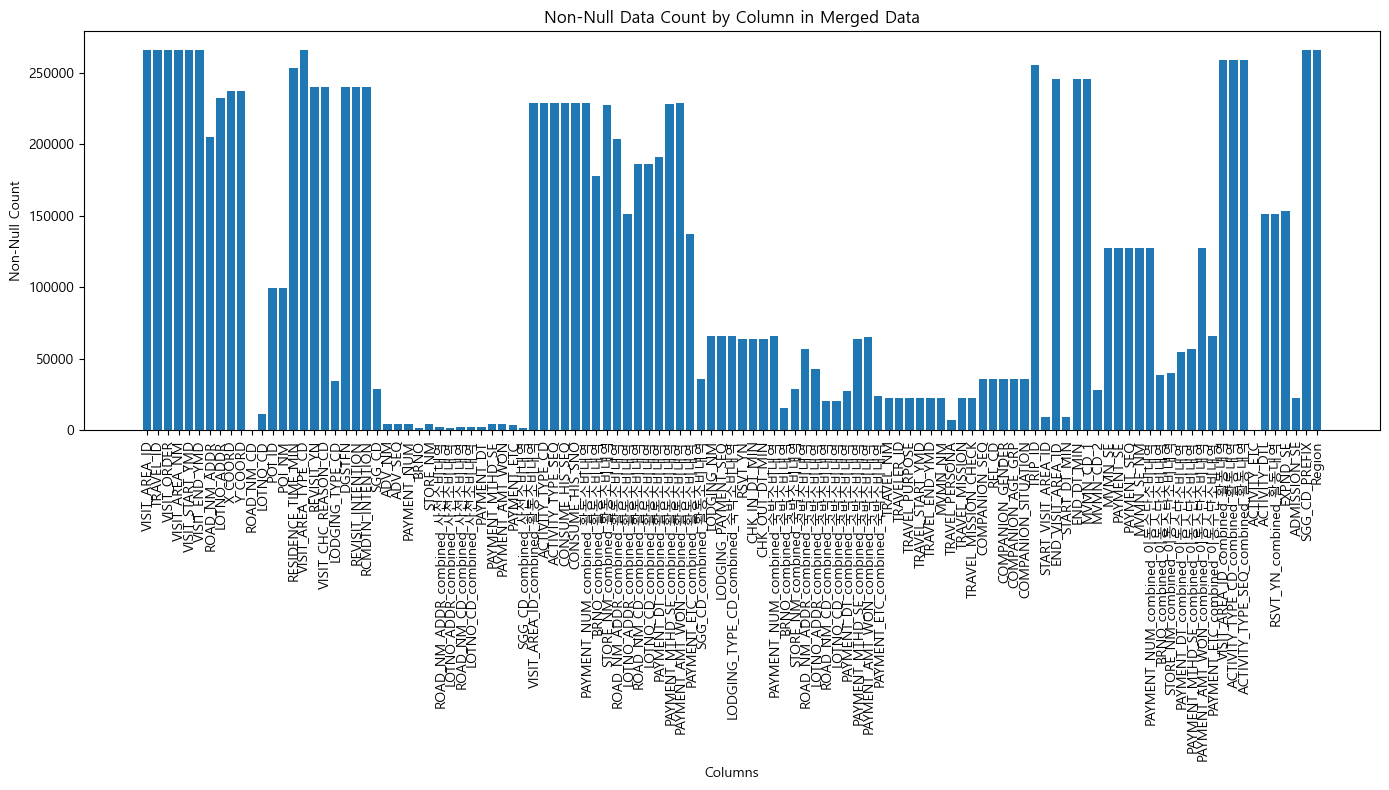

In [20]:
# 한글 폰트 설정
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
merged_data_path = "merged_data.csv"
merged_data = pd.read_csv(merged_data_path)
print("Merged data loaded successfully. Shape:", merged_data.shape)

# 각 열별 Non-Null 데이터 개수 계산
column_counts = merged_data.notnull().sum()

# 데이터프레임으로 변환
column_counts_df = pd.DataFrame({
    'Columns': column_counts.index,
    'Non-Null Count': column_counts.values
})

# 시각화
plt.figure(figsize=(14, 8))
plt.bar(column_counts_df['Columns'], column_counts_df['Non-Null Count'])
plt.xticks(rotation=90)
plt.title('Non-Null Data Count by Column in Merged Data')
plt.xlabel('Columns')
plt.ylabel('Non-Null Count')
plt.tight_layout()
plt.show()

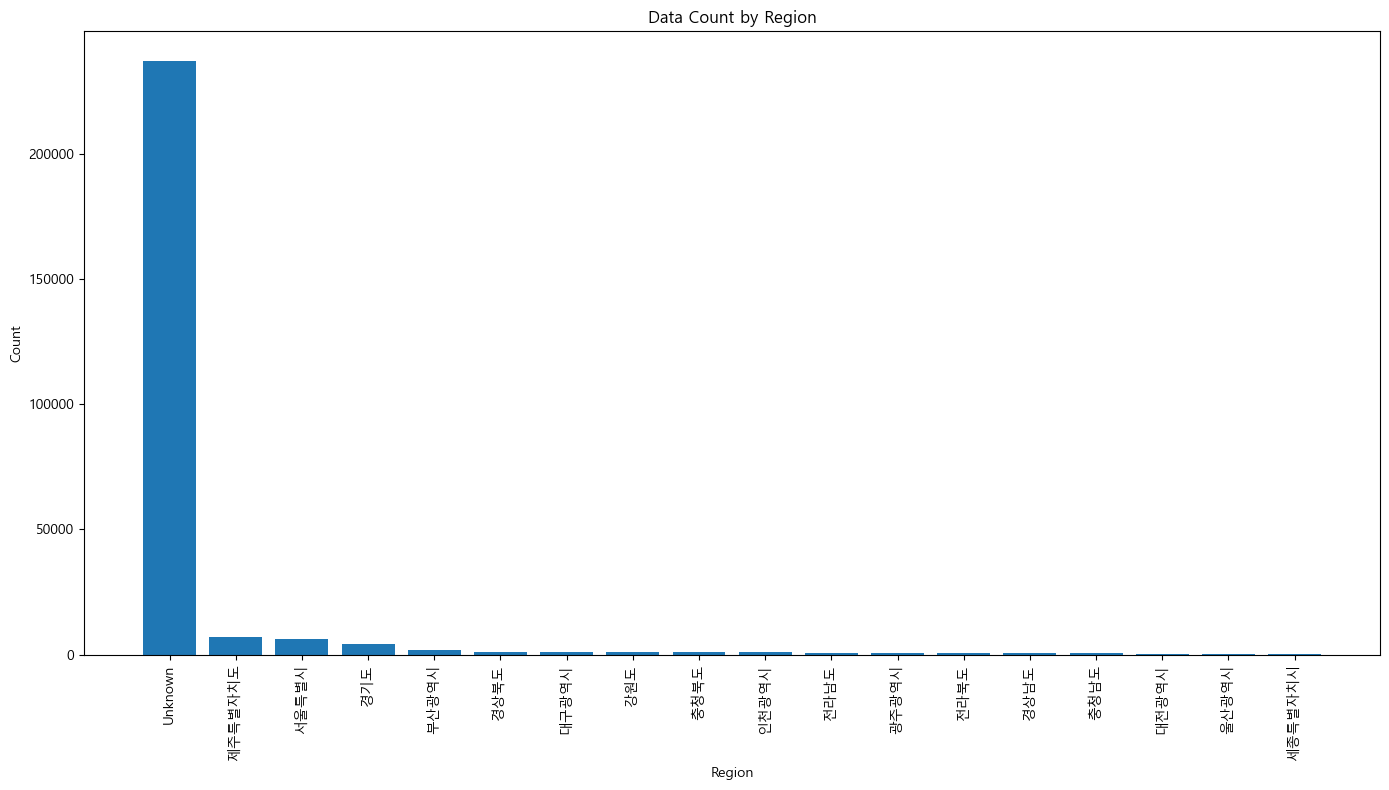

In [21]:
# Region 열 데이터 건수 계산
region_counts = merged_data['Region'].value_counts()

# 시각화
plt.figure(figsize=(14, 8))
plt.bar(region_counts.index, region_counts.values)
plt.xticks(rotation=90)
plt.title('Data Count by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Average data count per region (excluding Unknown): 1689.06


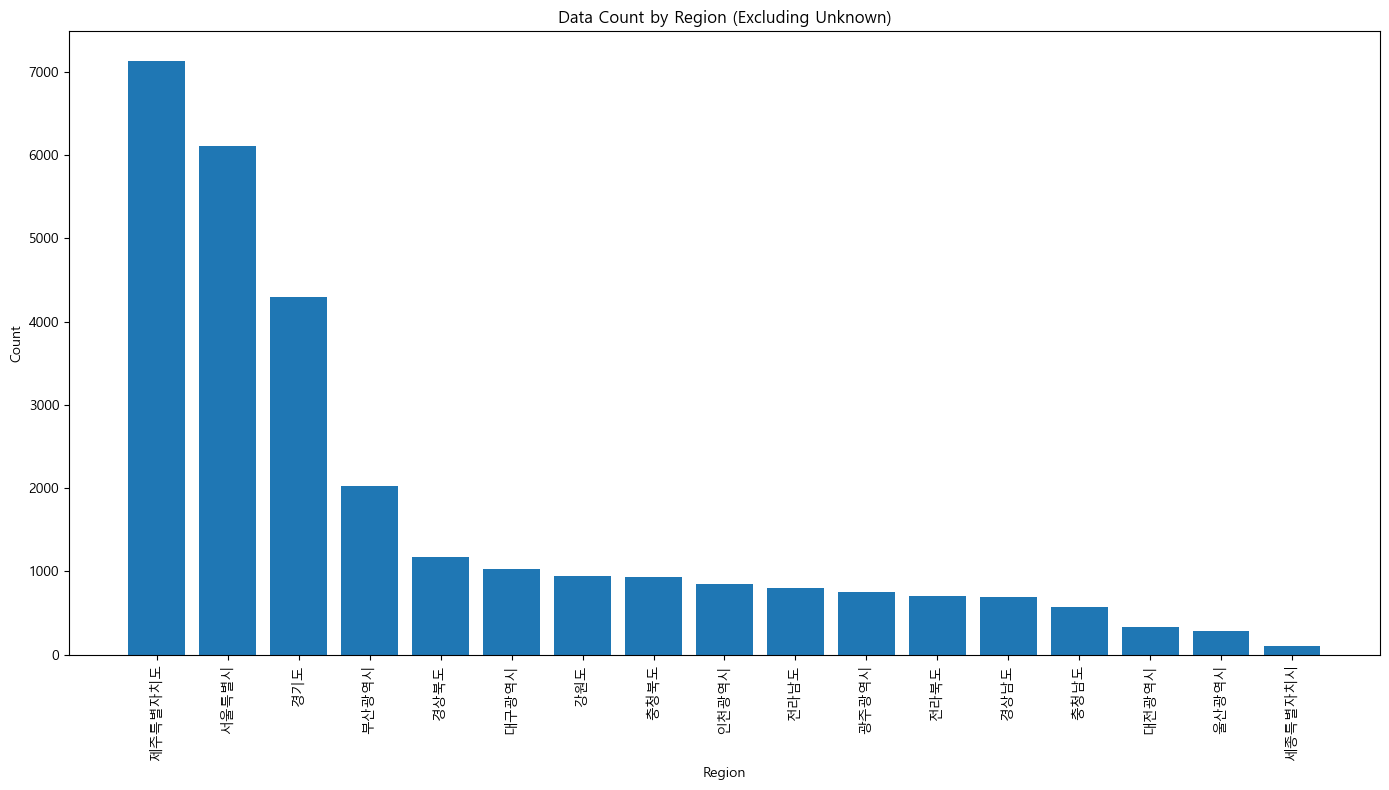

In [22]:
# Unknown 값 제외
filtered_data = merged_data[merged_data['Region'] != 'Unknown']

# Region 열 데이터 건수 계산
region_counts_filtered = filtered_data['Region'].value_counts()

# 평균 데이터 건수 계산
average_count = region_counts_filtered.mean()

print(f"Average data count per region (excluding Unknown): {average_count:.2f}")

# 시각화
plt.figure(figsize=(14, 8))
plt.bar(region_counts_filtered.index, region_counts_filtered.values)
plt.xticks(rotation=90)
plt.title('Data Count by Region (Excluding Unknown)')
plt.xlabel('Region')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# from scipy.stats import ttest_ind

# def perform_t_tests(data, target_col):
#     """
#     두 그룹 간 t-test 수행
#     :param data: 전체 데이터 (Pandas DataFrame)
#     :param target_col: 그룹화 기준 열 (e.g., 서울특별시/그외)
#     :return: t-test 결과 (t-statistic, p-value)
#     """
#     group1 = data[data[target_col] == "서울특별시"]
#     group2 = data[data[target_col] != "서울특별시"]

#     t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
#     print(f"t-statistic: {t_stat}, p-value: {p_val}")
#     return t_stat, p_val


In [ ]:
# from scipy.stats import chi2_contingency

# import matplotlib.pyplot as plt
# import seaborn as sns

# def perform_chi2_test(data, categorical_cols, target_col, visualize=True):
#     """
#     카이제곱 검정을 모든 범주형 변수에 대해 수행하고 결과를 시각화
#     :param data: 전체 데이터 (Pandas DataFrame)
#     :param categorical_cols: 비교할 범주형 변수 목록 (list of columns)
#     :param target_col: 그룹화 기준 열 (e.g., 서울특별시/그외)
#     :param visualize: 시각화 여부
#     :return: 카이제곱 통계량 및 p-value가 포함된 DataFrame
#     """
#     chi2_results = []

#     for col in categorical_cols:
#         if col != target_col:  # target_col은 제외
#             try:
#                 contingency_table = pd.crosstab(data[col], data[target_col])
#                 chi2, p_val, dof, expected = chi2_contingency(contingency_table)
#                 chi2_results.append({'Column': col, 'Chi2': chi2, 'p-value': p_val})
#             except Exception as e:
#                 print(f"Error processing column {col}: {e}")

#     # 결과를 데이터프레임으로 변환
#     chi2_results_df = pd.DataFrame(chi2_results)

#     if visualize:
#         # Chi-squared 값 시각화
#         plt.figure(figsize=(12, 6))
#         sns.barplot(data=chi2_results_df.sort_values(by='Chi2', ascending=False), x='Chi2', y='Column', palette='Blues_r')
#         plt.title("Chi-Squared Values for Categorical Features vs. Region")
#         plt.xlabel("Chi-Squared Value")
#         plt.ylabel("Categorical Feature")
#         plt.tight_layout()
#         plt.show()

#         # p-value 시각화
#         plt.figure(figsize=(12, 6))
#         sns.barplot(data=chi2_results_df.sort_values(by='p-value', ascending=True), x='p-value', y='Column', palette='Reds_r')
#         plt.title("p-values for Categorical Features vs. Region")
#         plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
#         plt.xlabel("p-value")
#         plt.ylabel("Categorical Feature")
#         plt.legend()
#         plt.tight_layout()
#         plt.show()

#     return chi2_results_df



In [ ]:
# from sklearn.cross_decomposition import CCA

# def perform_cca(X, Y, n_components=1):
#     """
#     Canonical Correlation Analysis (CCA)
#     :param X: 독립 변수 데이터 (Pandas DataFrame 또는 NumPy Array)
#     :param Y: 종속 변수 데이터 (Pandas DataFrame 또는 NumPy Array)
#     :param n_components: CCA의 주요 성분 수
#     :return: CCA 모델 및 변환된 데이터
#     """
#     cca = CCA(n_components=n_components)
#     X_c, Y_c = cca.fit_transform(X, Y)

#     # CCA 결과 출력
#     print(f"Canonical Correlation: {cca.score(X, Y):.4f}")
#     return cca, X_c, Y_c


In [ ]:
# def calculate_odds_ratio_and_ci(success_group1, total_group1, success_group2, total_group2, alpha=0.05):
#     """
#     Odds Ratio와 신뢰 구간 계산
#     :param success_group1: 그룹 1에서 성공 횟수
#     :param total_group1: 그룹 1의 전체 사례 수
#     :param success_group2: 그룹 2에서 성공 횟수
#     :param total_group2: 그룹 2의 전체 사례 수
#     :param alpha: 신뢰 구간의 유의 수준 (default=0.05)
#     :return: Odds Ratio, 신뢰 구간, p-value
#     """
#     # 실패 사례 계산
#     failure_group1 = total_group1 - success_group1
#     failure_group2 = total_group2 - success_group2

#     # Odds Ratio 계산
#     odds_ratio_value = (success_group1 / failure_group1) / (success_group2 / failure_group2)

#     # 신뢰 구간 계산
#     conf_int = confint_proportions_2indep(
#         count1=success_group1, nobs1=total_group1,
#         count2=success_group2, nobs2=total_group2,
#         method='wald', alpha=alpha
#     )

#     # p-value 계산 (test_proportions_2indep를 사용하지 않고 간단히 출력)
#     print(f"Odds Ratio: {odds_ratio_value:.4f}, Confidence Interval: {conf_int}")
#     return odds_ratio_value, conf_int

In [23]:
# 1. 전처리
# 결측치 처리
numeric_cols = merged_data.select_dtypes(include=['float', 'int']).columns
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(0)

categorical_cols = merged_data.select_dtypes(include=['object', 'category']).columns
merged_data[categorical_cols] = merged_data[categorical_cols].fillna('Unknown')

# 'Region' 열에서 'Unknown' 값 제거
merged_data = merged_data[merged_data['Region'] != 'Unknown']

# 데이터 크기 확인
print("Data shape after removing 'Unknown':", merged_data.shape)
print("Region value counts after removing 'Unknown':")
print(merged_data['Region'].value_counts())

Data shape after removing 'Unknown': (28714, 113)
Region value counts after removing 'Unknown':
Region
제주특별자치도    7132
서울특별시      6106
경기도        4296
부산광역시      2020
경상북도       1170
대구광역시      1032
강원도         943
충청북도        928
인천광역시       845
전라남도        803
광주광역시       747
전라북도        705
경상남도        692
충청남도        570
대전광역시       335
울산광역시       287
세종특별자치시     103
Name: count, dtype: int64


In [24]:
# 3. 데이터 준비
# X, y 분리
columns_to_drop = ['SGG_CD', 'SGG_CD_PREFIX', 'Region']
columns_in_data = [col for col in columns_to_drop if col in merged_data.columns]
X = merged_data.drop(columns=columns_in_data)
y = merged_data['Region']

# X에 포함된 모든 칼럼 이름 확인
columns_in_X = X.columns

# 총 칼럼 수와 함께 출력
print(f"Total columns in X: {len(columns_in_X)}")
print("Columns in X:")
for col in columns_in_X:
    print(col)

# 범주형 데이터 인코딩
for col in categorical_cols:
    if col in X.columns:  # X에 존재하는 열만 변환
        X[col] = X[col].astype(str)  # 모든 값을 문자열로 변환
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# 3. LabelEncoder로 Region 열 숫자 변환
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 변환된 Region 클래스 확인
regions = label_encoder.classes_

Total columns in X: 110
Columns in X:
VISIT_AREA_ID
TRAVEL_ID
VISIT_ORDER
VISIT_AREA_NM
VISIT_START_YMD
VISIT_END_YMD
ROAD_NM_ADDR
LOTNO_ADDR
X_COORD
Y_COORD
ROAD_NM_CD
LOTNO_CD
POI_ID
POI_NM
RESIDENCE_TIME_MIN
VISIT_AREA_TYPE_CD
REVISIT_YN
VISIT_CHC_REASON_CD
LODGING_TYPE_CD
DGSTFN
REVISIT_INTENTION
RCMDTN_INTENTION
ADV_NM
ADV_SEQ
PAYMENT_NUM
BRNO
STORE_NM
ROAD_NM_ADDR_combined_사전소비내역
LOTNO_ADDR_combined_사전소비내역
ROAD_NM_CD_combined_사전소비내역
LOTNO_CD_combined_사전소비내역
PAYMENT_DT
PAYMENT_MTHD_SE
PAYMENT_AMT_WON
PAYMENT_ETC
SGG_CD_combined_사전소비내역
VISIT_AREA_ID_combined_활동소비내역
ACTIVITY_TYPE_CD
ACTIVITY_TYPE_SEQ
CONSUME_HIS_SEQ
CONSUME_HIS_SNO
PAYMENT_NUM_combined_활동소비내역
BRNO_combined_활동소비내역
STORE_NM_combined_활동소비내역
ROAD_NM_ADDR_combined_활동소비내역
LOTNO_ADDR_combined_활동소비내역
ROAD_NM_CD_combined_활동소비내역
LOTNO_CD_combined_활동소비내역
PAYMENT_DT_combined_활동소비내역
PAYMENT_MTHD_SE_combined_활동소비내역
PAYMENT_AMT_WON_combined_활동소비내역
PAYMENT_ETC_combined_활동소비내역
SGG_CD_combined_활동소비내역
LODGING_NM
LODGING_PAYMENT_SEQ
LO

In [5]:
# 숫자 -> 원래 클래스 매핑 출력
mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print("Mapping of numeric values to original Region labels:")
for key, value in mapping.items():
    print(f"{key}: {value}")

print("Encoded Region classes:", regions)

# 데이터 크기 및 일부 값 확인
print("X shape:", X.shape)
print("y shape:", y.shape)

print("First few rows of X:")
print(X.head())
print("First few values of y:", y[:5])

print(y)

Mapping of numeric values to original Region labels:
0: 강원도
1: 경기도
2: 경상남도
3: 경상북도
4: 광주광역시
5: 대구광역시
6: 대전광역시
7: 부산광역시
8: 서울특별시
9: 세종특별자치시
10: 울산광역시
11: 인천광역시
12: 전라남도
13: 전라북도
14: 제주특별자치도
15: 충청남도
16: 충청북도
Encoded Region classes: ['강원도' '경기도' '경상남도' '경상북도' '광주광역시' '대구광역시' '대전광역시' '부산광역시' '서울특별시'
 '세종특별자치시' '울산광역시' '인천광역시' '전라남도' '전라북도' '제주특별자치도' '충청남도' '충청북도']
X shape: (28714, 110)
y shape: (28714,)
First few rows of X:
     VISIT_AREA_ID  TRAVEL_ID  VISIT_ORDER  VISIT_AREA_NM  VISIT_START_YMD  \
111     2210150001        643            1           1052               72   
112     2210150001        643            1           1052               72   
113     2210150001        643            1           1052               72   
114     2210150001        643            1           1052               72   
115     2210150001        643            1           1052               72   

     VISIT_END_YMD  ROAD_NM_ADDR  LOTNO_ADDR  X_COORD  Y_COORD  ...  \
111             72             0   

In [25]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (28714, 110)
y shape: (28714,)


In [26]:
# 2. 범주형 열 확인
categorical_cols = merged_data.select_dtypes(include=['object', 'category']).columns
print("Categorical columns in merged_data:")
print(categorical_cols)

Categorical columns in merged_data:
Index(['TRAVEL_ID', 'VISIT_AREA_NM', 'VISIT_START_YMD', 'VISIT_END_YMD',
       'ROAD_NM_ADDR', 'LOTNO_ADDR', 'LOTNO_CD', 'POI_ID', 'POI_NM',
       'REVISIT_YN', 'ADV_NM', 'STORE_NM', 'ROAD_NM_ADDR_combined_사전소비내역',
       'LOTNO_ADDR_combined_사전소비내역', 'PAYMENT_DT', 'PAYMENT_ETC',
       'STORE_NM_combined_활동소비내역', 'ROAD_NM_ADDR_combined_활동소비내역',
       'LOTNO_ADDR_combined_활동소비내역', 'PAYMENT_DT_combined_활동소비내역',
       'PAYMENT_ETC_combined_활동소비내역', 'LODGING_NM', 'RSVT_YN', 'CHK_IN_DT_MIN',
       'CHK_OUT_DT_MIN', 'STORE_NM_combined_숙박소비내역',
       'ROAD_NM_ADDR_combined_숙박소비내역', 'LOTNO_ADDR_combined_숙박소비내역',
       'PAYMENT_DT_combined_숙박소비내역', 'PAYMENT_ETC_combined_숙박소비내역',
       'TRAVEL_NM', 'TRAVELER_ID', 'TRAVEL_PURPOSE', 'TRAVEL_START_YMD',
       'TRAVEL_END_YMD', 'MVMN_NM', 'TRAVEL_PERSONA', 'TRAVEL_MISSION',
       'TRAVEL_MISSION_CHECK', 'START_DT_MIN', 'END_DT_MIN', 'PAYMENT_SE',
       'MVMN_SE_NM', 'STORE_NM_combined_이동수단소비내역',
      

In [ ]:
# # 2. 통계 분석 수행

# # 1) CCA 분석
# # y를 숫자형으로 변환
# if y.dtype != 'float':
#     y = y.astype(float)

# cca, X_c, Y_c = perform_cca(X, y)

# # 2) T-Test 수행
# # Region이 숫자형이어야 함
# if merged_data['Region'].dtype != 'int':
#     merged_data['Region'] = merged_data['Region'].astype('category').cat.codes

# t_stat, p_val = perform_t_tests(data=merged_data, target_col='Region')

# # 3) Chi2 검정 수행
# # categorical_feature이 문자열이어야 함
# if 'categorical_feature' in merged_data.columns:
#     if merged_data['categorical_feature'].dtype != 'object':
#         merged_data['categorical_feature'] = merged_data['categorical_feature'].astype(str)

# chi2, chi2_p_val = perform_chi2_test(
#     data=merged_data, 
#     categorical_col='categorical_feature', 
#     target_col='Region'
# )

# # 4) Odds Ratio와 CI 계산
# odds_ratio_val, odds_p_val = calculate_odds_ratio_and_ci(
#     success_group1=100, total_group1=200,
#     success_group2=150, total_group2=300
# )

In [27]:
def create_output_directory(base_dir="results"):
    """
    결과 저장 디렉토리를 생성
    """
    idx = 1
    new_dir = base_dir
    # 파일 존재 여부 확인
    while os.path.exists(new_dir):
        if os.path.isfile(new_dir):  # 파일일 경우 에러 방지
            raise OSError(f"{new_dir} exists as a file, cannot create directory.")
        new_dir = f"{base_dir}{idx}"
        idx += 1
    # 디렉토리 생성
    os.makedirs(new_dir, exist_ok=True)
    return new_dir

In [39]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold , KFold

# Nested CV 함수 정의
def perform_nested_cv(model, param_grid, X, y, cv_outer=5, cv_inner=3):
    """
    Nested CV 수행 및 결과 반환
    :param model: 학습 모델
    :param param_grid: 하이퍼파라미터 공간
    :param X: 특징 데이터셋
    :param y: 타겟 데이터셋
    :param cv_outer: 외부 CV 분할 개수
    :param cv_inner: 내부 CV 분할 개수
    :return: 평균 성능 및 표준 편차
    """
    outer_cv = StratifiedKFold(n_splits=cv_outer, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=cv_inner, shuffle=True, random_state=42)

    nested_scores = []

    for train_idx, test_idx in outer_cv.split(X, y):
        # 외부 루프: Train/Test Split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # 내부 루프: 하이퍼파라미터 튜닝
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        # 외부 테스트 데이터로 성능 평가
        best_model = grid_search.best_estimator_
        score = best_model.score(X_test, y_test)
        nested_scores.append(score)

    # 평균 및 표준 편차 계산
    mean_score = np.mean(nested_scores)
    std_score = np.std(nested_scores)
    return mean_score, std_score




In [40]:
import seaborn as sns
from sklearn.base import clone


# SHAP 분석
def perform_shap_analysis(model, X_test, output_dir, model_name, region):
    """
    SHAP 분석을 수행하고 결과를 시각화 및 저장
    """
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        # 단일 클래스 또는 다중 클래스 처리
        if isinstance(shap_values, list):
            for i, class_shap_values in enumerate(shap_values):
                shap.summary_plot(class_shap_values, X_test, show=False)
                plt.title(f"SHAP Summary (Class {i}) for {model_name} ({region})")
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f"shap_summary_class_{i}_{model_name}_{region}.png"))
                plt.close()
        else:
            shap.summary_plot(shap_values, X_test, show=False)
            plt.title(f"SHAP Summary for {model_name} ({region})")
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"shap_summary_{model_name}_{region}.png"))
            plt.close()
    except Exception as e:
        print(f"SHAP analysis failed for {model_name} in {region}: {e}")


# LIME 분석
def perform_lime_analysis(model, X_test, output_dir, model_name, region, sample_idx=0):
    """
    LIME 분석을 수행하고 결과를 저장
    """
    explainer = LimeTabularExplainer(
        training_data=X_test.values,
        feature_names=X_test.columns.tolist(),
        class_names=["Not " + region, region],
        discretize_continuous=True,
    )

    explanation = explainer.explain_instance(
        X_test.iloc[sample_idx].values,
        model.predict_proba,
        num_features=10,
    )

    # 결과 저장
    explanation.save_to_file(os.path.join(output_dir, f"lime_explanation_{model_name}_{region}_sample_{sample_idx}.html"))
    fig = explanation.as_pyplot_figure()
    plt.title(f"LIME Explanation for Sample {sample_idx} - {model_name} ({region})")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"lime_explanation_{model_name}_{region}_sample_{sample_idx}.png"))
    plt.close()


def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test, region, output_dir):
    """
    모델 학습, 주요 피처 시각화 및 성능 평가
    """
    # 모델 학습
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # 성능 계산
    results = {
        "model_name": model_name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob) if y_prob is not None else None,
    }

    # 주요 피처 계산 및 시각화 (10, 30, 100개)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]  # 중요도가 높은 순서로 정렬

        for n_features in [10, 30, 100]:
            # 상위 N개 피처 추출
            top_features = X_train.columns[sorted_idx][:n_features]
            top_importances = importances[sorted_idx][:n_features]

            # 피처 중요도 시각화
            plt.figure(figsize=(12, 8))
            sns.barplot(x=top_importances, y=top_features, orient="h")
            plt.title(f"Top {n_features} Feature Importance for {model_name} ({region})")
            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"feature_importance_{model_name}_{region}_top_{n_features}.png"))
            plt.close()

            # 상위 N개 피처로 성능 평가를 위해 새로운 모델 생성
            new_model = clone(model)  # 기존 모델을 복사
            X_train_subset = X_train[top_features]
            X_test_subset = X_test[top_features]

            # 모델 재학습 및 평가
            new_model.fit(X_train_subset, y_train)
            y_pred_subset = new_model.predict(X_test_subset)
            y_prob_subset = new_model.predict_proba(X_test_subset)[:, 1] if hasattr(new_model, "predict_proba") else None

            # 성능 계산
            subset_results = {
                "accuracy": accuracy_score(y_test, y_pred_subset),
                "precision": precision_score(y_test, y_pred_subset),
                "recall": recall_score(y_test, y_pred_subset),
                "f1_score": f1_score(y_test, y_pred_subset),
                "roc_auc": roc_auc_score(y_test, y_prob_subset) if y_prob_subset is not None else None,
            }
            results[f"top_{n_features}_performance"] = subset_results

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    results["conf_matrix"] = conf_matrix

    # Confusion Matrix 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name} ({region})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"conf_matrix_{model_name}_{region}.png"))
    plt.close()

    # ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results['roc_auc']:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {model_name} ({region})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"roc_curve_{model_name}_{region}.png"))
        plt.close()

    # PR Curve
    if y_prob is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.figure()
        plt.plot(recall, precision, label=f"{model_name}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"PR Curve for {model_name} ({region})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"pr_curve_{model_name}_{region}.png"))
        plt.close()

    return results


# 모델 처리 및 SHAP/LIME 분석 실행
overall_results = []
output_dir = create_output_directory()

# 특정 지역(서울특별시) 처리
region = "서울특별시"
region_idx = list(label_encoder.classes_).index(region)
y_binary = (y == region_idx).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
X_train = pd.DataFrame(X_train, columns=X.columns)  # DataFrame으로 변환
X_test = pd.DataFrame(X_test, columns=X.columns)    # DataFrame으로 변환
y_train = pd.Series(y_train)  # Series로 변환
y_test = pd.Series(y_test)    # Series로 변환

region_dir = os.path.join(output_dir, region)
os.makedirs(region_dir, exist_ok=True)


# 모델 정의
models = {
    "Random Forest": (RandomForestClassifier(random_state=42), {"n_estimators": [10, 50, 100]}),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42), {"n_estimators": [10, 50, 100]}),
    "LightGBM": (LGBMClassifier(random_state=42,force_row_wise=True), {"n_estimators": [10, 50, 100]}),
    "CatBoost": (CatBoostClassifier(verbose=0, random_state=42), {"iterations": [100, 200, 300]}),
}

# 모델 훈련 및 평가
for model_name, (model, param_grid) in models.items():  # 모델과 파라미터 그리드를 분리
    try:
        # 모델 학습 및 평가 (튜플에서 모델 객체만 전달)
        results = train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test, region, region_dir)
        overall_results.append(results)

        # # SHAP 분석
        # perform_shap_analysis(model, X_test, region_dir, model_name, region)

        # # LIME 분석
        # perform_lime_analysis(model, X_test, region_dir, model_name, region)
        # SHAP 분석
        perform_shap_analysis(model, X_test, region_dir, model_name, region)

        # LIME 분석
        perform_lime_analysis(model, X_test, region_dir, model_name, region)

    except Exception as e:
        print(f"Error processing {model_name} for {region}: {e}")

# Nested CV 수행
# Perform Nested CV
nested_cv_results = {}
for model_name, (model, param_grid) in models.items():
    try:
        print(f"Performing Nested CV for {model_name}...")
        mean_score, std_score = perform_nested_cv(model, param_grid, X, y)  # Ensure X and y are Pandas objects
        nested_cv_results[model_name] = (mean_score, std_score)
        print(f"{model_name}: {mean_score:.4f} ± {std_score:.4f}")
    except Exception as e:
        print(f"Error during Nested CV for {model_name}: {e}")

# 결과 저장
results_df = pd.DataFrame(overall_results)
results_df.to_csv(os.path.join(output_dir, "overall_results.csv"), index=False)

nested_results_df = pd.DataFrame.from_dict(
    nested_cv_results, orient="index", columns=["Mean Accuracy", "Std Deviation"]
)
nested_results_df.to_csv(os.path.join(output_dir, "nested_cv_results.csv"), index=True)

c:\Users\user\anaconda3\envs\travel\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\travel\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\user\anaconda3\envs\travel\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\user\anaconda3\envs\travel\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:22:29] WARNING: C:\buildkite-agent\builds\buildki

[LightGBM] [Info] Number of positive: 4864, number of negative: 18107
[LightGBM] [Info] Total Bins 9817
[LightGBM] [Info] Number of data points in the train set: 22971, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211745 -> initscore=-1.314437
[LightGBM] [Info] Start training from score -1.314437
[LightGBM] [Info] Number of positive: 4864, number of negative: 18107
[LightGBM] [Info] Total Bins 2024
[LightGBM] [Info] Number of data points in the train set: 22971, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211745 -> initscore=-1.314437
[LightGBM] [Info] Start training from score -1.314437
[LightGBM] [Info] Number of positive: 4864, number of negative: 18107
[LightGBM] [Info] Total Bins 5364
[LightGBM] [Info] Number of data points in the train set: 22971, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211745 -> initscore=-1.314437
[LightGBM] [Info] Start training from score -1.314437
[Light

c:\Users\user\anaconda3\envs\travel\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


Performing Nested CV for Random Forest...
Error during Nested CV for Random Forest: 'numpy.ndarray' object has no attribute 'iloc'
Performing Nested CV for XGBoost...
Error during Nested CV for XGBoost: 'numpy.ndarray' object has no attribute 'iloc'
Performing Nested CV for LightGBM...
Error during Nested CV for LightGBM: 'numpy.ndarray' object has no attribute 'iloc'
Performing Nested CV for CatBoost...
Error during Nested CV for CatBoost: 'numpy.ndarray' object has no attribute 'iloc'
